# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>
    
This course is based on specific versions of python packages. You can find the details of the same in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>. The manual also explains how to use these codes in other versions of python packages. <BR>

# Floor & Ceiling: Swing Calculation

 
Regime calculation using floor and ceiling is a three-step process. This method, while conceptually simple, is computationally more involved. In this notebook, we will calculate swings and discuss them in detail.

1. Swing calculation: We want to calculate all the swing highs and lows. A swing low is when price makes a low and is immediately followed by two consecutive higher lows. Likewise, a swing high is when the price makes a high and is followed by two consecutive lower highs. We need swings to alternate: swing high follows a swing low and vice versa. We also want to eliminate cases where swing lows are higher than swing highs. In practice, we will make use of the scipy library to calculate swing highs and lows. We will use a built-in function called argrelextrema. This function calculates peaks and troughs over several periods. 

This notebook is divided in the following parts:
1. Create the swings
2. Perform Alternation
3. Perform Adjustment
4. Compare the graphs


## Import libraries

In [48]:
# Data analysis and manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# Calculates swing highs and lows
from scipy.signal import *
from scipy.signal import argrelextrema

# To plot
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Import data

### File names: 
1. Jan_2010_to_Jan_2019_Rebased_Series.

This data is available in the last unit of this course. You can find this file in the downloadables section of the course. We import these data by using the pandas function 'pandas.read_csv()'. This function will read the comma-separated values (CSV) file into dataframe.

In [49]:
relative_path = "../data_modules/"
# Reads and imports the rebased series using the function 'read_csv'
data = pd.read_csv(
    relative_path + 'Jan_2010_to_Jan_2019_Rebased_Series.csv', index_col=0, parse_dates=True)

# Set index in datetime format
data.index = pd.to_datetime(data.index)

# Returns the top two rows of the dataframe
data.head(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,relative_close,rebased_open,rebased_high,rebased_low,rebased_close
Date,,,,,,,,,,,,,,,
2010-01-04,15.24,15.75,15.12,15.69,0.62,113.33,70.35,0.22,0.22,0.21,0.22,15.24,15.75,15.12,15.69
2010-01-05,15.74,16.21,15.70,16.20,0.63,113.63,71.06,0.22,0.23,0.22,0.23,15.58,16.05,15.54,16.04


## 1. Create swings

Markets are composed of local highs and lows commonly referred to as swing highs and swing lows. A bull market pauses when all-new swing highs fail to take the peak, or highest swing high. Market turns bearish when swing highs are materially lower than the peak. 
Conversely, bear market pauses when new swing lows fail to penetrate the lowest swing low or bottom. Market turns bullish when new swing lows are distinctively higher than the bottom.

In [50]:
# Create a high_low dataset
high_low = data[['rebased_high', 'rebased_low', 'rebased_close']]

# Returns the top two rows of the dataframe
high_low.head(2)

,rebased_high,rebased_low,rebased_close
Date,,,
2010-01-04,15.75,15.12,15.69
2010-01-05,16.05,15.54,16.04


In [51]:
# Set the argel_window as 20
argrel_window = 20

# Create 2 lists of highs and lows using argrelextrema
highs_list = argrelextrema(
    high_low['rebased_high'].values, np.greater, order=argrel_window)
lows_list = argrelextrema(
    high_low['rebased_low'].values, np.less, order=argrel_window)

In [52]:
# Create swing high and low columns and assign values from the lists
# The values 0 & 1 represent the [rows,columns]
high_low['swing_low'] = high_low.iloc[lows_list[0], 1]
high_low['swing_high'] = high_low.iloc[highs_list[0], 0]

In [53]:
# Copy the already existing dataframe.
# We will manipulate and reduce this dataframe and preserve the original
high_low_preprocess = high_low.copy()

# Returns the last two rows of the dataset
high_low.tail(2)

,rebased_high,rebased_low,rebased_close,swing_low,swing_high
Date,,,,,
2018-12-31,8.95,8.73,8.83,NaN,NaN
2019-01-02,8.82,8.42,8.75,NaN,NaN


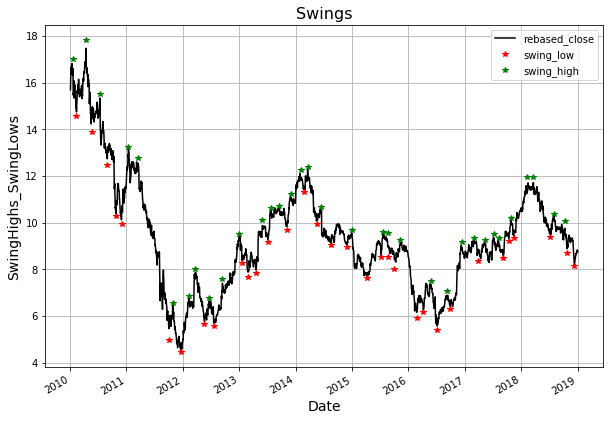

In [54]:
# Plot the graph
high_low[['rebased_close', 'swing_low', 'swing_high']].plot(
    style=['k-', 'r*', 'g*'], figsize=(10, 7))
plt.title('Swings', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('SwingHighs_SwingLows', fontsize=14)

# Add legend to the plot
plt.legend()
# Add grid to the plot
plt.grid()
# Display the graph
plt.show()

## 2. Perform alternation

In alternation, we want highs to follow lows and keep the most extreme values of the swing and eliminate the rest.

This alternation sorting algorithm is more memory efficient and faster than looping through the entire set. We use a while loop and limit iterations to 5 times as we don't know how many times iterations would be required. It only loops over potential swing highs and lows and gets the job done usually in 2 loops. However, it has one drawback. We cannot join this dataframe to the original one if there are already columns with identical headers. This becomes an issue when updating the dataframe. We, therefore, need to check if columns are in the original dataframe, drop them before joining.

In [55]:
# Create a unified column with peaks<0 and troughs>0
high_low['swing_high_low'] = high_low['swing_low'].sub(
    high_low['swing_high'], fill_value=0)

Step 1: The function 'dropna' drops all rows with no swings

In [56]:
high_low = high_low.dropna(subset=['swing_high_low']).copy()

Step 2: Eliminate all the swings low higher than highs. For comparison, compare the graphs.

In [57]:
high_low.loc[(high_low['swing_high_low'].shift(1) * high_low['swing_high_low'] < 0) &
             (high_low['swing_high_low'].shift(1) < 0) & (np.abs(high_low['swing_high_low'].shift(1)) < high_low['swing_high_low']), 'swing_high_low'] = np.nan

In [58]:
# Returns the top 5 rows of the dataset
high_low.head()

,rebased_high,rebased_low,rebased_close,swing_low,swing_high,swing_high_low
Date,,,,,,
2010-01-21,17.00,15.51,15.78,NaN,17.00,-17.00
2010-02-12,14.84,14.57,14.74,14.57,NaN,14.57
2010-04-15,17.81,17.36,17.47,NaN,17.81,-17.81
2010-05-25,14.59,13.90,14.54,13.90,NaN,13.90
2010-07-15,15.52,14.89,15.22,NaN,15.52,-15.52


Step 3: Eliminates all the earlier lower values

In [59]:
high_low.loc[(high_low['swing_high_low'].shift(1) * high_low['swing_high_low'] > 0) &
             (high_low['swing_high_low'].shift(1) < high_low['swing_high_low']), 'swing_high_low'] = np.nan

In [60]:
# Returns the top 5 rows of the dataset
high_low.head()

,rebased_high,rebased_low,rebased_close,swing_low,swing_high,swing_high_low
Date,,,,,,
2010-01-21,17.00,15.51,15.78,NaN,17.00,-17.00
2010-02-12,14.84,14.57,14.74,14.57,NaN,14.57
2010-04-15,17.81,17.36,17.47,NaN,17.81,-17.81
2010-05-25,14.59,13.90,14.54,13.90,NaN,13.90
2010-07-15,15.52,14.89,15.22,NaN,15.52,-15.52


Step 4: Eliminates subsequent lower values

In [61]:
high_low.loc[(high_low['swing_high_low'].shift(-1) * high_low['swing_high_low'] > 0) &
             (high_low['swing_high_low'].shift(-1) < high_low['swing_high_low']), 'swing_high_low'] = np.nan

In [62]:
# Returns the top 5 rows of the dataset
high_low.head()

,rebased_high,rebased_low,rebased_close,swing_low,swing_high,swing_high_low
Date,,,,,,
2010-01-21,17.00,15.51,15.78,NaN,17.00,-17.00
2010-02-12,14.84,14.57,14.74,14.57,NaN,14.57
2010-04-15,17.81,17.36,17.47,NaN,17.81,-17.81
2010-05-25,14.59,13.90,14.54,13.90,NaN,13.90
2010-07-15,15.52,14.89,15.22,NaN,15.52,-15.52


In [63]:
#Reduce the dataframe
high_low = high_low.dropna(subset=['swing_high_low']).copy()

# Returns the top 5 rows of the dataset
high_low.head()

,rebased_high,rebased_low,rebased_close,swing_low,swing_high,swing_high_low
Date,,,,,,
2010-01-21,17.00,15.51,15.78,NaN,17.00,-17.00
2010-02-12,14.84,14.57,14.74,14.57,NaN,14.57
2010-04-15,17.81,17.36,17.47,NaN,17.81,-17.81
2010-05-25,14.59,13.90,14.54,13.90,NaN,13.90
2010-07-15,15.52,14.89,15.22,NaN,15.52,-15.52


### Looping all the four steps in a while loop:
1. Drop all rows with no swings using the function 'dropna' 
2. Eliminate all the swings low higher than highs. For comparison, compare the graphs.
3. Eliminates all the earlier lower values
4. Eliminates subsequent lower values


We want the swing highs to be followed by swing lows and only want to keep the extreme values. At times, during a bull run, swing highs are followed by swing highs. We have to eliminate such repeated swing highs and lows using a while loop.

The objective is to alternate highs and lows efficiently. So, we create a unified column. Highs are negative and Lows are positive. We have to make sure the sign of the product of two consecutive values is negative and look for the lowest value for the lows and highs. We do not know how many times we will have to loop. We, therefore, use a while loop and limit iterations to 5 times. We eliminate every row with NaN values. We iterate until all NaN has disappeared.

In [64]:
# Instantiate start
i = 0
# Drop all rows with no swing
high_low = high_low.dropna(subset=['swing_high_low']).copy()

while ((high_low['swing_high_low'].shift(1) * high_low['swing_high_low'] > 0)).any():
    # Eliminate the lows higher than highs
    high_low.loc[(high_low['swing_high_low'].shift(1) * high_low['swing_high_low'] < 0) &
                 (high_low['swing_high_low'].shift(1) < 0) & (np.abs(high_low['swing_high_low'].shift(1)) < high_low['swing_high_low']), 'swing_high_low'] = np.nan
    # Eliminates earlier lower values
    high_low.loc[(high_low['swing_high_low'].shift(1) * high_low['swing_high_low'] > 0) &
                 (high_low['swing_high_low'].shift(1) < high_low['swing_high_low']), 'swing_high_low'] = np.nan
    # Eliminates subsequent lower values
    high_low.loc[(high_low['swing_high_low'].shift(-1) * high_low['swing_high_low'] > 0) &
                 (high_low['swing_high_low'].shift(-1) < high_low['swing_high_low']), 'swing_high_low'] = np.nan
    # Reduce the dataframe
    high_low = high_low.dropna(subset=['swing_high_low']).copy()
    i += 1
    # Avoid infinite loop
    if i == 4:
        break

In [65]:
# Returns the top 5 rows of the dataset
high_low.head()

,rebased_high,rebased_low,rebased_close,swing_low,swing_high,swing_high_low
Date,,,,,,
2010-01-21,17.00,15.51,15.78,NaN,17.00,-17.00
2010-02-12,14.84,14.57,14.74,14.57,NaN,14.57
2010-04-15,17.81,17.36,17.47,NaN,17.81,-17.81
2010-05-25,14.59,13.90,14.54,13.90,NaN,13.90
2010-07-15,15.52,14.89,15.22,NaN,15.52,-15.52


In [66]:
# Join with existing dataframe as pandas cannot join columns with the same headers
# Check if the columns are in the dataframe
if 'swing_low' in data.columns:
     # If so, drop them
    data.drop(['swing_low', 'swing_high'], axis=1, inplace=True)
# Then, join swing high lows
data = data.join(high_low[['swing_low', 'swing_high']])

In [67]:
# Returns the top two rows of the dataset
data.head(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,relative_close,rebased_open,rebased_high,rebased_low,rebased_close,swing_low,swing_high
Date,,,,,,,,,,,,,,,,,
2010-01-04,15.24,15.75,15.12,15.69,0.62,113.33,70.35,0.22,0.22,0.21,0.22,15.24,15.75,15.12,15.69,NaN,NaN
2010-01-05,15.74,16.21,15.70,16.20,0.63,113.63,71.06,0.22,0.23,0.22,0.23,15.58,16.05,15.54,16.04,NaN,NaN


## 3. Perform adjustment

The method finds an extreme and will reset only after the number of set periods elapses. This means it can find a swing high that would be lower than the current price. This only happens with the latest swing. We, therefore, need to make a manual adjustment. 

In [68]:
# Prepare for the Last swing adjustment, if the last_sign <0: swing high, if > 0 swing low
last_swing = np.sign(high_low['swing_high_low'][-1])

In [69]:
# Instantiate last swing high and low dates
last_swing_low_dates = data[data['swing_low'] > 0].index.max()
last_swing_high_dates = data[data['swing_high'] > 0].index.max()

In [70]:
# Print the last swing low dates
print(last_swing_low_dates)

2018-12-10 00:00:00


In [71]:
# Print the last swing high dates
print(last_swing_high_dates)

2018-07-30 00:00:00


Test for extreme values:

In [72]:
# Swing_high_date is not equal to highest high date since swing_low
if (last_swing == -1) & (last_swing_high_dates != data[last_swing_low_dates:]['swing_high'].idxmax()):
    # Reset swing_high to NaN
    data.loc[last_swing_high_dates, 'swing_high'] = np.nan
# Swing_high_date is not equal to highest high date since swing_low
elif (last_swing == 1) & (last_swing_low_dates != data[last_swing_high_dates:]['swing_low'].idxmax()):
    # Reset swing_low to NaN
    data.loc[last_swing_low_dates, 'swing_low'] = np.nan

## 4. Compare graphs

Plot and compare the three graphs:
1. Dataframe with raw swing highs and lows
2. Dataframe after alternation
3. Dataframe after adjustments and joining

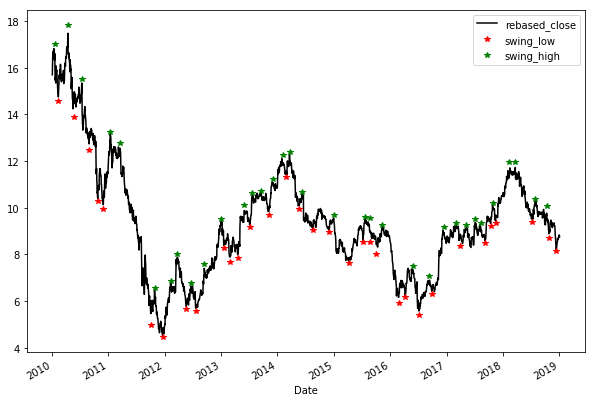

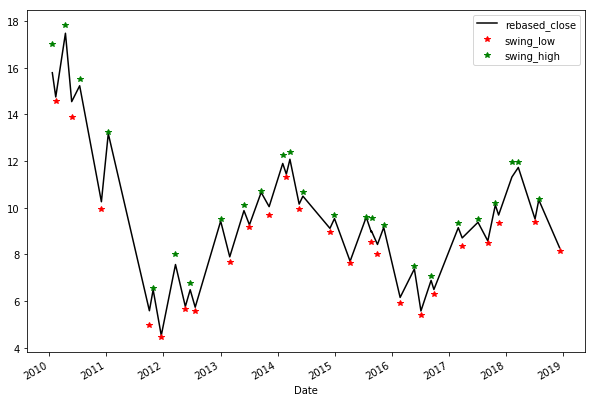

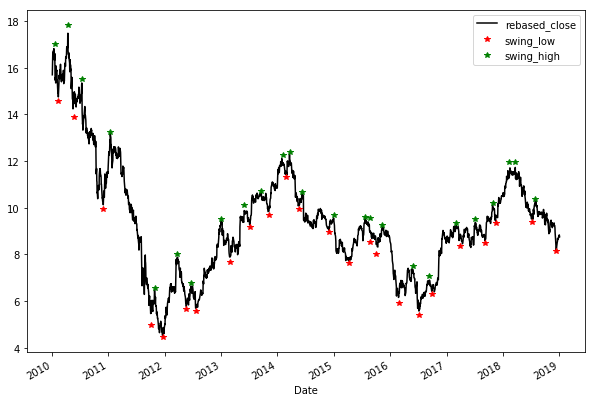

In [73]:
# This is the dataframe with raw swing highs and lows.
high_low_preprocess[['rebased_close', 'swing_low', 'swing_high']].plot(
    style=['k-', 'r*', 'g*'], figsize=(10, 7))

# This is the high_low dataframe after the alternation process
high_low[['rebased_close', 'swing_low', 'swing_high']].plot(
    style=['k-', 'r*', 'g*'], figsize=(10, 7))

# This is the main dataframe after joining. Note the adjustments: consecutive lows/highs, lows<highs and last swing
data[['rebased_close', 'swing_low', 'swing_high']].plot(
    style=['k-', 'r*', 'g*'], figsize=(10, 7))
plt.show()

## Create a swing function:

All the three steps i.e.
1. Create swings
2. Alternation
3. And, last swing adjustment

can be put down together by creating a swings function, 'swings'. Let's learn how to calculate a swings function.

        '''
        df: relative series dataframe 
        high: dataframe's high
        low:  dataframe's low
        argel window: default 20 for daily bars
        '''


In [74]:
def swings(df, high, low, argrel_window):

    # Create swings:

    # Step 1: copy existing df. We will manipulate and reduce this df and want to preserve the original
    high_low = df[[high, low]].copy()

    # Step 2: build 2 lists of highs and lows using argrelextrema
    highs_list = argrelextrema(
        high_low[high].values, np.greater, order=argrel_window)
    lows_list = argrelextrema(
        high_low[low].values, np.less, order=argrel_window)

    # Step 3: Create swing high and low columns and assign values from the lists
    swing_high = 's' + str(high)[-12:]
    swing_low = 's' + str(low)[-12:]
    high_low[swing_low] = high_low.iloc[lows_list[0], 1]
    high_low[swing_high] = high_low.iloc[highs_list[0], 0]

# Alternation: We want highs to follow lows and keep the most extreme values

    # Step 4. Create a unified column with peaks<0 and troughs>0
    swing_high_low = str(high)[:2]+str(low)[:2]
    high_low[swing_high_low] = high_low[swing_low].sub(
        high_low[swing_high], fill_value=0)

    # Step 5: Reduce dataframe and alternation loop
    # Instantiate start
    i = 0
    # Drops all rows with no swing
    high_low = high_low.dropna(subset=[swing_high_low]).copy()
    while ((high_low[swing_high_low].shift(1) * high_low[swing_high_low] > 0)).any():
        # eliminate lows higher than highs
        high_low.loc[(high_low[swing_high_low].shift(1) * high_low[swing_high_low] < 0) &
                     (high_low[swing_high_low].shift(1) < 0) & (np.abs(high_low[swing_high_low].shift(1)) < high_low[swing_high_low]), swing_high_low] = np.nan
        # eliminate earlier lower values
        high_low.loc[(high_low[swing_high_low].shift(1) * high_low[swing_high_low] > 0) & (
            high_low[swing_high_low].shift(1) < high_low[swing_high_low]), swing_high_low] = np.nan
        # eliminate subsequent lower values
        high_low.loc[(high_low[swing_high_low].shift(-1) * high_low[swing_high_low] > 0) & (
            high_low[swing_high_low].shift(-1) < high_low[swing_high_low]), swing_high_low] = np.nan
        # reduce dataframe
        high_low = high_low.dropna(subset=[swing_high_low]).copy()
        i += 1
        if i == 4:  # avoid infinite loop
            break

    # Step 6: Join with existing dataframe as pandas cannot join columns with the same headers
    # First, we check if the columns are in the dataframe
    if swing_low in df.columns:
        # If so, drop them
        df.drop([swing_low, swing_high], axis=1, inplace=True)
    # Then, join columns
    df = df.join(high_low[[swing_low, swing_high]])

# Last swing adjustment:

    # Step 7: Preparation for the Last swing adjustment
    high_low[swing_high_low] = np.where(
        np.isnan(high_low[swing_high_low]), 0, high_low[swing_high_low])
    # If last_sign <0: swing high, if > 0 swing low
    last_sign = np.sign(high_low[swing_high_low][-1])

    # Step 8: Instantiate last swing high and low dates
    last_slo_dt = df[df[swing_low] > 0].index.max()
    last_shi_dt = df[df[swing_high] > 0].index.max()

    # Step 9: Test for extreme values
    if (last_sign == -1) & (last_shi_dt != df[last_slo_dt:][swing_high].idxmax()):
            # Reset swing_high to nan
        df.loc[last_shi_dt, swing_high] = np.nan
    elif (last_sign == 1) & (last_slo_dt != df[last_shi_dt:][swing_low].idxmax()):
        # Reset swing_low to nan
        df.loc[last_slo_dt, swing_low] = np.nan

    return (df)

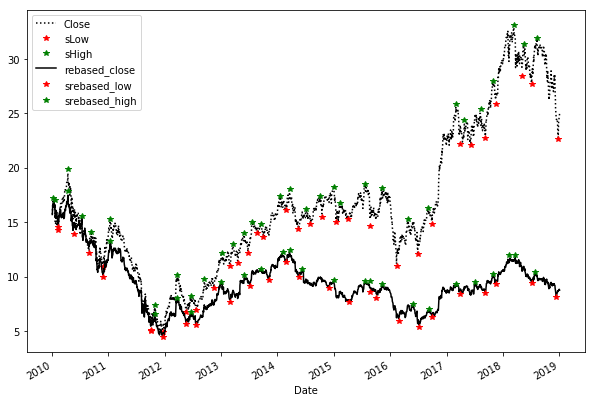

In [75]:
# Plot the graphs
data = swings(df=data, high='High', low='Low', argrel_window=20)
data = swings(df=data, high='rebased_high',
              low='rebased_low', argrel_window=20)
data[['Close', 'sLow', 'sHigh', 'rebased_close', 'srebased_low', 'srebased_high']].plot(
    style=['k:', 'r*', 'g*', 'k-', 'r*', 'g*'], figsize=(10, 7))
plt.show()

## Conclusion

The swing high and low method can be applied to identifying the trends in the market. The swing high and low methods can help you to identify mainly the support and resistance levels. Using the above information you can easily trade the downtrend or even the uptrend when the regime direction changes.

In the next notebook, we will learn how to use these swing highs and lows to calculate the distance between the subsequent peak and trough in units of volatility.
</span> <BR><BR>
